<h1 style="text-align:center;line-height:1.5em;font-size:30px;">Data and Scripts <br>for CNN-based Drainage Feature Object Detection<br> Using Faster RCNN</h1>

<p style="text-align:center;font-size:12px;">
<strong>Department of Geography and Environmental Resources, Southern Illinois University Carbondale, IL, USA</strong><br>
</p>
<h1 style="text-align:center;line-height:1.5em;font-size:30px;">Processing the DEM using Least cost path</h1>

<hr>

**Notebook Structure**
<br> 
 Codes 
 1. CNN  Model Development
 2. FRCNN Detection <br>
 3. Bounding Box Coordinates Processing <br>
 4. Process the DEM using Least Cost Path ** <br>
 5. Hydrological Streamline detection Using UNet <br>

** Indicates Active Notebook
 

***
### Find  depressions and extract start and end point of crossing river


This part of the code will find potential depressions in each clipped DEM following these process.

1. Fill the DEM
2. Find the difference between filled DEM and original DEM
3. Reclassify the DEM using natural break = 10
4. Select regions with two min values(The region with the lowest elevation)
5. Regions with top two largest areas are selected as mask
6. Select one depression from each region, using its central point as starting/ending point
Based on different rules
7. The paired depression with nearest distance 
8. Average Depth of each depression



***

#### Run the block below to install required libraries

You have to restart the kernel after running the code block below.

In [ ]:
# Install required libraries for processing.
#!pip install --user scikit-image
# !pip install --user numpy
# !pip install --user pandas
# !pip install --user jenkspy
# !pip install --user gdal
# !pip install --user scipy
# !pip install --user matplotlib
# !pip install --user rasterio
# !pip install --user shapely
# !pip install --user pillow
#!pip install --user richdem
# Please restart the kernel after this block finished running.

In [1]:
# !pip install scikit-image
# !pip install numpy
# !pip install pandas
# !pip install jenkspy
# !pip install scipy
# !pip install matplotlib
# !pip install rasterio
# !pip install shapely
# !pip install pillow


<h3> Fill DEM using RichDEM and save the result </h3>

In [1]:
import os, sys
from skimage import io
import glob
import tifffile as tiff
import math
import numpy as np
import pandas as pd
import jenkspy
from osgeo import gdal, ogr,osr
import matplotlib.pyplot as plt
from scipy import ndimage
import heapq
import rasterio.features
import shapely.geometry
from PIL import Image
import richdem as rd


data_dir = r"C:\Users\mikeb\Desktop\FRCNN_predict\DEM_data\clipped_output"
out_dir = r"C:\Users\mikeb\Desktop\FRCNN_predict\DEM_data\filled"

#Fill the DEM using RichDEM
def fillDem(data_dir, out_dir):
    for filename in os.listdir(data_dir):
        if filename.endswith('.tif'): 
            beau = rd.LoadGDAL(os.path.join(data_dir, filename), 1)
            beau_filled = rd.FillDepressions(beau, in_place=False)
            rd.SaveGDAL(os.path.join(out_dir, filename.replace(".tif", "_fld_.tif")), beau_filled) 

print("Filling DEM...")
fillDem(data_dir, out_dir)
print("Filling DEM completed successfully!")
    

Filling DEM...
Filling DEM completed successfully!


<h3> Read both Filled DEM and Original DEM and save as array

In [1]:
import glob
import tifffile as tiff
import numpy as np

path = "C:/Users/mikeb/Desktop/FRCNN_predict/DEM_data/clipped_output"   # DEM for test
pathFl = "C:/Users/mikeb/Desktop/FRCNN_predict/DEM_data/filled"

# Read all images
def read_img(folder):
    imgs = []
    for im in glob.glob(folder + "/*.tif"):
        img = tiff.imread(im)
#         print(im)
        imgs.append(img)
    return np.stack(imgs,axis = 0).astype(np.float32)

imgdata = read_img(path)
imgdataFl = read_img(pathFl)  # filled DEM
print(imgdata.shape)
print(imgdataFl.shape)




(25, 100, 100)
(25, 100, 100)


<h3>Classify using nature break and sort result</h3>

In [4]:

Dif = np.empty((imgdata.shape[0],imgdata.shape[1],imgdata.shape[2]))
# print(Dif.shape)

#Substract the Filled Dem from the Original DEM
for i in range (imgdata.shape[0]):
    Dif[i,:,:]=imgdataFl[i,:,:]-imgdata[i,:,:]
       
#Create an empty array
ReclsImg=np.empty((imgdata.shape[0],100,100),dtype=int)

#Classify the DEM using a natural breaks, Class = 10
for i in range (imgdata.shape[0]):
    Newlist=imgdata[i,:,:].flatten()
#     print(Newlist.shape)
    breaks = jenkspy.jenks_breaks(Newlist,n_classes = 10) # nature break=10
    countCls=2 #select min 2 classes
#     print(breaks)
    for j in range(100):
        for k in range(100):
            if imgdata[i,j,k]<=breaks[countCls]:# find potential depressions
                ReclsImg[i,j,k]=1
            else:
                ReclsImg[i,j,k]=0
    
    labels, nfeatures = ndimage.label(ReclsImg[i,:,:])
    
    # print('----')
    # print(i)
    
    if nfeatures<2: # feature num should >2
        while nfeatures<2 and countCls<10:
            countCls+=1
            for j1 in range(100):
                for k1 in range(100):
                    if imgdata[i,j1,k1]<=breaks[countCls]:# find potential depressions
                        ReclsImg[i,j1,k1]=1
                    else:
                        ReclsImg[i,j1,k1]=0
            labels, nfeatures = ndimage.label(ReclsImg[i,:,:])
            # print (nfeatures)
    
          

# print (ReclsImg[4,:,:])
# print (ReclsImg.shape[2])
# plt.imshow(ReclsImg[1,:,:])


SrtP_1=[] # Point for test 1
EndP_1=[] 

SrtP_2=[] # Point for test 2
EndP_2=[] 

SrtP_3=[] # Point for test 3
EndP_3=[] 

SrtP_4=[] # Point for test 4
EndP_4=[] 

SrtP_5=[] # Point for test 5
EndP_5=[] 

SrtP_6=[] # Point for test 6
EndP_6=[] 

SrtP_7=[] # Point for test 7
EndP_7=[] 

SrtP_8=[] # Point for test 8
EndP_8=[] 

SrtP_9=[] # Point for test 9
EndP_9=[] 


<h3>Determine Startpoint and Endpoints</h3>

In [5]:

#Create mask
def MaskGenerate(LabeledImg,label):
    mask=np.zeros([LabeledImg.shape[0],LabeledImg.shape[1]])
    for r in range (LabeledImg.shape[0]):
        for c in range (LabeledImg.shape[1]):
            if LabeledImg[r,c]==label:
                mask[r,c]=1
            else: 
                mask[r,c]=0
    return mask

#Clip the mask
def MaskClip(mask, clipedImg):
    MaskClp=np.zeros([mask.shape[0],mask.shape[1]])
    for r in range (mask.shape[0]):
        for c in range (mask.shape[1]):            
            if mask[r,c]==1:
                MaskClp[r,c]=clipedImg[r,c]
            else:
                MaskClp[r,c]=0.0
    return MaskClp
    

#Depth calculation
def DepthMean(DEM,img):
    labels, nfeatures = ndimage.label(img)
    sizes=(labels==(np.arange(nfeatures)+1)[:,None,None]).sum((1,2))
    # print(labels,nfeatures,sizes)
    DepMeans=[]
    for i in range(nfeatures):
        DepSum=0.0
        for j in range (DEM.shape[0]):
            for k in range (DEM.shape[1]):                            
                if labels[j,k]==i+1:
                    DepSum=DepSum+DEM[j,k]
        # print (DepSum)
        
        DepMean=DepSum/sizes[i]
        DepMeans.append(DepMean)
    return DepMeans

#Find Central point    
def centralPFind(ss):
    RPs=[]
    
    for k in range(len(ss)):
        if ss[k][1]!=0: # 0 is background
            cor=ss[k][0]['coordinates']
            if len(cor)==1:
                Dep=shapely.geometry.Polygon(cor[0]) # regions without hole
            if len(cor)>1:
                inners=[]
                for n in range(1,len(cor)):
                    inners.append(cor[n])
                Dep=shapely.geometry.Polygon(cor[0],[inner for inner in inners])# regions with holes in it
            RP=list(Dep.representative_point().coords) # within geometric object
            RPs.append(RP)
    return RPs
 
   
def Edis(p1,p2):
    dis=((p1[0][0]-p2[0][0])**2+(p1[0][1]-p2[0][1])**2)**0.5
    return dis

def NorMinMax(array):
    mx=np.nanmax(array)
    mn=np.nanmin(array)
    t=(array-mn)/(mx-mn+0.0001)
    return t

def Polygon_perimeter(img):
    labelsPM, nfeaturesPM = ndimage.label(img)
    tots=[]
    a=len(img)
    b=len(img[0])
    for i in range (1,nfeaturesPM+1):
        tot=0
        for aa in range (a):
            for bb in range (b):
                if labelsPM[aa][bb]==i:
                    # tot+=1
                    if aa==0 or labelsPM[aa-1][bb]!=i: tot+=1
                    if aa==a-1 or labelsPM[aa+1][bb]!=i: tot+=1
                    if bb==0 or labelsPM[aa][bb -1]!=i: tot+=1
                    if bb==b-1 or labelsPM[aa][bb+1]!=i: tot+=1
        tots.append(tot)
    return tots
        
def compactness(P,A):
    c=P**2/(4*A*math.pi)
    return c


def Snd_Max(Lst):
    one=Lst[0]
    second=0
    for i in range(1,len(Lst)):
        if Lst[i]>one:
            second=one
            one=Lst[i]
        elif Lst[i]>second:
            second=Lst[i]
    return second



for j in range (ReclsImg.shape[0]):
    labels, nfeatures = ndimage.label(ReclsImg[j,:,:]) # label contiguous regions of non-zero elements
    # labels is an array which labels different region with different numbers(just as a raster)
    # nfeatures is the number of regions
    

    sizes=(labels==(np.arange(nfeatures)+1)[:,None,None]).sum((1,2)) # sizes of each region
 
    arrLo=[]
    arrLo=heapq.nlargest(2, range(len(sizes)),key=sizes.__getitem__) # find locations (labeled #) of two largest regions in array

    
    ####### if NB only has one region, reset the NB and calculate arrLo again    
    if len(arrLo)<2:
        Newlist_edt=imgdata[j,:,:].flatten()
        breaks_edt = jenkspy.jenks_breaks(Newlist_edt,nb_class = 5) # nature break=5
        countCls=1 #select min 1 classes
        # print(breaks)
        for j_edt in range(99):
            for k_edt in range(99):
                if imgdata[j,j_edt,k_edt]<=breaks_edt[countCls]:# find potential depressions
                    ReclsImg[j,j_edt,k_edt]=1
                else:
                    ReclsImg[j,j_edt,k_edt]=0
        
        labels, nfeatures = ndimage.label(ReclsImg[j,:,:])
        
        # print('----')
        # print(i)
        
        if nfeatures<2: # feature num should >2
            while nfeatures<2 and countCls<5:
                countCls+=1
                for j1_edt in range(99):
                    for k1_edt in range(99):
                        if imgdata[j,j1_edt,k1_edt]<=breaks[countCls]:# find potential depressions
                            ReclsImg[j,j1_edt,k1_edt]=1
                        else:
                            ReclsImg[j,j1_edt,k1_edt]=0
                labels, nfeatures = ndimage.label(ReclsImg[j,:,:])
           
        
        sizes=(labels==(np.arange(nfeatures)+1)[:,None,None]).sum((1,2)) # sizes of each region
        # print(sizes)
        arrLo=[]
        arrLo=heapq.nlargest(2, range(len(sizes)),key=sizes.__getitem__)        
        

    if len(arrLo)>1:
        maxLabel=(arrLo[0])+1 # Largest location label number from Nature break
        SndmaxLabel=(arrLo[1])+1
        
        mask1=MaskGenerate(labels,maxLabel)
        mask2=MaskGenerate(labels,SndmaxLabel) # 2 largest regions from NB
             
        MaskClp1=MaskClip(mask1,Dif[j,:,:]) # Differece in NB regions
        MaskClp2=MaskClip(mask2,Dif[j,:,:])
        
  
        
        if MaskClp1.any(): # there is no depression in NB region
            labels1, nfeatures1 = ndimage.label(MaskClp1)                        
        else:
            labels1, nfeatures1 = ndimage.label(mask1)
            
       
        if MaskClp2.any():
            labels2, nfeatures2 = ndimage.label(MaskClp2)            
        else:
            labels2, nfeatures2 = ndimage.label(mask2) # use all NB region as a 'depression'
       
        # print('--nf2',nfeatures2)
        # print(labels2)


        ########### Test 1. nearest distance ###############################
        
        shapes1=rasterio.features.shapes(labels1)
        ss1=list(shapes1)
        
        shapes2=rasterio.features.shapes(labels2)
        ss2=list(shapes2) # boundary coordinate for each polygon
        
        P1=centralPFind(ss1) # find central point for each depression
        P2=centralPFind(ss2) 
        
        P1=np.array(P1)
        P2=np.array(P2) # shape:(total point number,1,2)
        # print(P1[1,:,:])
        
        P12Dis=np.zeros([P1.shape[0],P2.shape[0]])
        for p1 in range (P1.shape[0]):
            for p2 in range (P2.shape[0]):
                P12Dis[p1,p2]=Edis(P1[p1,:,:],P2[p2,:,:])
        MinCoor=np.where(P12Dis==np.min(P12Dis)) # find closest paired point
        P1num=MinCoor[0][0]
        P2num=MinCoor[1][0]
        # print(P2num)

        
        SrtP_1.append(P1[P1num,:,:].flatten())
        EndP_1.append(P2[P2num,:,:].flatten())
        
        
        ########### Test 2. Depth and Area ###############################
        score1=[]
        score2=[]
        
        DepM1=np.array(DepthMean(Dif[j,:,:],MaskClp1)) # mean depth for each depression(Filled-DEM) in selected NB region
        DepM2=np.array(DepthMean(Dif[j,:,:],MaskClp2))       
        # print(DepM1.shape[0])
        # print(DepM1[0])
       
        sizes1=(labels1==(np.arange(nfeatures1)+1)[:,None,None]).sum((1,2)) # areas
        sizes2=(labels2==(np.arange(nfeatures2)+1)[:,None,None]).sum((1,2))
        # print(sizes1.shape[0])
        # print('--sizes2',sizes2)
        
               
        # Normalize the dataset-MaxMin

        if DepM1.any():            
            DepM1_scl = NorMinMax(DepM1)# there is one (or multi) depression in NB regions
        else: # DepMean= 0 as there is no depression. NorMaxMin doesn't work (Zero-size array/single number can't be applied to Min,Max function)
            DepM1_scl = 1 #there is no depression in NB region, using whole NB region as a 'depression' (area with hlowest  elevation).
       
        if DepM2.any():  
            DepM2_scl = NorMinMax(DepM2)
        else:
            DepM2_scl = 1

        
        sizes1_scl = NorMinMax(sizes1)
        sizes2_scl = NorMinMax(sizes2)
        # print(sizes1.shape,sizes1_scl.shape)
        
        
        
        for n in range (DepM1.shape[0]):
            sco1=0.5*DepM1_scl[n]+0.5*sizes1_scl[n]
            score1.append(sco1)
            
        for m in range (DepM2.shape[0]):
            sco2=0.5*DepM2_scl[m]+0.5*sizes2_scl[m]
            score2.append(sco2)
            
        # print(score2)
        
        if len(score1)>1:
            HstScore1=np.where(score1==np.max(score1)) # find location of highest score
            # print(HstScore1)
            P1_Sc_num=HstScore1[0][0]
            # print(P1_Sc_num)
        else: # only have one depression, can't use max
            P1_Sc_num=0 # only contain one central point in array P. (theh first value is the only value)
        
        
        if len(score2)>1:
            HstScore2=np.where(score2==np.max(score2))
            P2_Sc_num=HstScore2[0][0]
        else:
            P2_Sc_num=0
        # print(P2_Sc_num)
        # print(HstScore1,HstScore2)
        
        
        
        # print(P1_Sc_num)
        
        SrtP_2.append(P1[P1_Sc_num,:,:].flatten())
        EndP_2.append(P2[P2_Sc_num,:,:].flatten())
        
 
        ########### Test 3. Compactness ###############################       
        if MaskClp1.any():
            periM1=Polygon_perimeter(MaskClp1)
        else:
            periM1=Polygon_perimeter(mask1)
            
        
        if MaskClp2.any():       
            periM2=Polygon_perimeter(MaskClp2)
        else:
            periM2=Polygon_perimeter(mask2) # no depression in NB, periM2=Polygon_perimeter(MaskClp2) is empty
        # print('--pm2',periM2)
        # print('----')
        
        Comp1=[]
        Comp2=[]
        for cc1 in range (nfeatures1):            
            c1=compactness(periM1[cc1],sizes1[cc1])
            Comp1.append(c1)
        
        for cc2 in range (nfeatures2):            
            c2=compactness(periM2[cc2],sizes2[cc2])
            Comp2.append(c2)
        
        # print(Comp1,Comp2)
        # print('---')
        
        HstComp1=np.where(Comp1==np.max(Comp1)) # find location of highest compactness
        HstComp2=np.where(Comp2==np.max(Comp2))
        
        # print(HstComp1)
        
        P1_Comp_num=HstComp1[0][0]
        P2_Comp_num=HstComp2[0][0]
        # print(P1_Comp_num)
        
        SrtP_3.append(P1[P1_Comp_num,:,:].flatten())
        EndP_3.append(P2[P2_Comp_num,:,:].flatten())
 

      
        # ########### Test 4. Compactness based on all depressions from NB ###############################

        # CompAll=Comp1+Comp2 # combine list
        # P_All_num= P1.shape[0]+P2.shape[0]
        # P_All=np.zeros([P_All_num,1,2]) # combine point x,y
        
        # for pn1 in range (P1.shape[0]):
        #     P_All[pn1,0,0]=P1[pn1,0,0]
        #     P_All[pn1,0,1]=P1[pn1,0,1]
       
        # for pn2 in range (P2.shape[0]):
        #     P_All[P1.shape[0]+pn2,0,0]=P2[pn2,0,0]
        #     P_All[P1.shape[0]+pn2,0,1]=P2[pn2,0,1]
        
        # # print(P_All)
        
        # CompAll_Max_cor=np.where(CompAll==(np.max(CompAll)))[0][0]
        # # print(CompAll_Max_cor)
        # SrtP_4.append(P_All[CompAll_Max_cor,:,:].flatten())
        
        # CompAll_SndMax_cor=np.where(CompAll==(Snd_Max(CompAll)))[0][0]
        # EndP_4.append(P_All[CompAll_SndMax_cor,:,:].flatten())
        
        
        ########### Test 6. score2=0.3 area +0.7 depth ###############################       
       
        score1_2=[]
        score2_2=[]
        
        
        
        
        for n1 in range (DepM1.shape[0]):
            sco1_2=0.7*DepM1_scl[n1]+0.3*sizes1_scl[n1]
            score1_2.append(sco1_2)
            
        for m1 in range (DepM2.shape[0]):
            sco2_2=0.7*DepM2_scl[m1]+0.3*sizes2_scl[m1]
            score2_2.append(sco2_2)
            
  
        # HstScore1_2=np.where(score1_2==np.max(score1_2)) # find location of highest score
        # HstScore2_2=np.where(score2_2==np.max(score2_2))
        
        # # print(HstScore1_2,HstScore2_2)
        
        # P1_Sc_num_2=HstScore1_2[0][0]
        # P2_Sc_num_2=HstScore2_2[0][0]
        # # print(P1_Sc_num_2)
        
        
        
        if len(score1_2)>1:
            HstScore1_2=np.where(score1_2==np.max(score1_2)) # find location of highest score            
            P1_Sc_num_2=HstScore1_2[0][0]            
        else: # only have one depression, can't use max
            P1_Sc_num_2=0 # only contain one central point in array P. (theh first value is the only value)
        
        
        if len(score2_2)>1:
            HstScore2_2=np.where(score2_2==np.max(score2_2))
            P2_Sc_num_2=HstScore2_2[0][0]
        else:
            P2_Sc_num_2=0
        
        
        
        
        
        SrtP_6.append(P1[P1_Sc_num_2,:,:].flatten())
        EndP_6.append(P2[P2_Sc_num_2,:,:].flatten())
        
 

        ########### Test 7. score_dp=0 area +1 depth ###############################       
       
        score1_dp=[]
        score2_dp=[]
        
        
        
        
        for n2 in range (DepM1.shape[0]):
            sco1_dp=1*DepM1_scl[n2]+0*sizes1_scl[n2]
            score1_dp.append(sco1_dp)
            
        for m2 in range (DepM2.shape[0]):
            sco2_dp=1*DepM2_scl[m2]+0*sizes2_scl[m2]
            score2_dp.append(sco2_dp)
            
  
        # HstScore1_dp=np.where(score1_dp==np.max(score1_dp)) # find location of highest score
        # HstScore2_dp=np.where(score2_dp==np.max(score2_dp))
       
        
        # P1_Sc_num_dp=HstScore1_dp[0][0]
        # P2_Sc_num_dp=HstScore2_dp[0][0]
        
        
        if len(score1_dp)>1:
            HstScore1_dp=np.where(score1_dp==np.max(score1_dp)) # find location of highest score
            P1_Sc_num_dp=HstScore1_dp[0][0]            
        else: # only have one depression, can't use max
            P1_Sc_num_dp=0 # only contain one central point in array P. (theh first value is the only value)
        
        
        if len(score2_dp)>1:
            HstScore2_dp=np.where(score2_dp==np.max(score2_dp))
            P2_Sc_num_dp=HstScore2_dp[0][0]
        else:
            P2_Sc_num_dp=0
        
        
        SrtP_7.append(P1[P1_Sc_num_dp,:,:].flatten())
        EndP_7.append(P2[P2_Sc_num_dp,:,:].flatten())



        ########### Test 8. score3=0.25 area + 0.25 depth+ 0.5 compactness ###############################       
       
        score1_3=[]
        score2_3=[]
        
        
        
        
        for n3 in range (DepM1.shape[0]):
            sco1_3=0.25*DepM1_scl[n3]+0.25*sizes1_scl[n3]+0.5*Comp1[n3]
            score1_3.append(sco1_3)
            
        for m3 in range (DepM2.shape[0]):
            sco2_3=0.25*DepM2_scl[m3]+0.25*sizes2_scl[m3]+0.5*Comp2[m3]
            score2_3.append(sco2_3)
            
  
        # HstScore1_3=np.where(score1_3==np.max(score1_3)) # find location of highest score
        # HstScore2_3=np.where(score2_3==np.max(score2_3))
        
        
        
        # P1_Sc_num_3=HstScore1_3[0][0]
        # P2_Sc_num_3=HstScore2_3[0][0]
        
        
        if len(score1_3)>1:
            HstScore1_3=np.where(score1_3==np.max(score1_3)) # find location of highest score
            P1_Sc_num_3=HstScore1_3[0][0]            
        else: # only have one depression, can't use max
            P1_Sc_num_3=0 # only contain one central point in array P. (theh first value is the only value)
        
        
        if len(score2_3)>1:
            HstScore2_3=np.where(score2_3==np.max(score2_3))
            P2_Sc_num_3=HstScore2_3[0][0]
        else:
            P2_Sc_num_3=0
        
        
        
        
        SrtP_8.append(P1[P1_Sc_num_3,:,:].flatten())
        EndP_8.append(P2[P2_Sc_num_3,:,:].flatten())

###########

    # if len(arrLo)<2:
    #     maxLabel=(arrLo[0])+1
    #     SndmaxLabel=(arrLo[0])+1


    ########### Test 5. Compactness of NB (no area) then Dif ###############################
        
    Comp=[]
    periM=Polygon_perimeter(labels)
    for cc in range (nfeatures):            
        c=compactness(periM[cc],sizes[cc])
        Comp.append(c)
    # print (Comp)
    
    CompLo=[]
    CompLo=heapq.nlargest(2, range(len(Comp)),key=Comp.__getitem__) # find locations (labeled #) of two regions with largest compactness
    # print(CompLo)
    
    if len(CompLo)>1:
        maxLabel_Comp=(CompLo[0])+1 # Largest compactness location label number from Nature break
        SndmaxLabel_Comp=(CompLo[1])+1
        
        mask_Comp1=MaskGenerate(labels,maxLabel_Comp)
        mask_Comp2=MaskGenerate(labels,SndmaxLabel_Comp) # 2 regions from NB with largest comp
             
        MaskClp_Comp1=MaskClip(mask_Comp1,Dif[j,:,:]) # Differece in NB regions
        MaskClp_Comp2=MaskClip(mask_Comp2,Dif[j,:,:])
        
        # print(MaskClp2.shape)
        # plt.imshow(mask1)
        # plt.show()
        # plt.imshow(mask2)
        # plt.show()
        # plt.imshow(MaskClp1)
        # plt.show()
        # plt.imshow(MaskClp2)
        # plt.show()
        
        labels_Comp1, nfeatures_Comp1 = ndimage.label(MaskClp_Comp1)
        labels_Comp2, nfeatures_Comp2 = ndimage.label(MaskClp_Comp2)
        
        ##########nearest
        
        shapes_Comp1=rasterio.features.shapes(labels_Comp1)
        ss_Comp1=list(shapes_Comp1)
        
        shapes_Comp2=rasterio.features.shapes(labels_Comp2)
        ss_Comp2=list(shapes_Comp2) # boundary coordinate for each polygon
        
        P_Comp1=centralPFind(ss_Comp1) # find central point for each depression
        P_Comp2=centralPFind(ss_Comp2) 
        
        P_Comp1=np.array(P_Comp1)
        P_Comp2=np.array(P_Comp2) # shape:(total point number,1,2)
        # print(P_Comp1.shape)
        
        P12Dis_Comp=np.zeros([P_Comp1.shape[0],P_Comp2.shape[0]])
        for p_Comp1 in range (P_Comp1.shape[0]):
            for p_Comp2 in range (P_Comp2.shape[0]):
                P12Dis_Comp[p_Comp1,p_Comp2]=Edis(P_Comp1[p_Comp1,:,:],P_Comp2[p_Comp2,:,:])
        MinCoor_Comp=np.where(P12Dis_Comp==np.min(P12Dis_Comp)) # find closest paired point
        P_Comp1num=MinCoor_Comp[0][0]
        P_Comp2num=MinCoor_Comp[1][0]
        # print(P_Comp2num)

        
        SrtP_5.append(P_Comp1[P_Comp1num,:,:].flatten())
        EndP_5.append(P_Comp2[P_Comp2num,:,:].flatten())



    

# print(SrtP_6,'----',SrtP_2,'----',EndP_6,'----',EndP_2)        
    
print(SrtP_1)
print(EndP_1)

# np.save("D:/Task3/TauDEMBurnNE0615/LCPA_FC/FC1SrtP.npy", SrtP_1) # working
# np.save("D:/Task3/TauDEMBurnNE0615/LCPA_FC/FC1EndP.npy", EndP_1)

# np.save("D:/Task2/ResultOct4/Test2SrtP.npy", SrtP_2)
# np.save("D:/Task2/ResultOct4/Test2EndP.npy", EndP_2)

# np.save("D:/Task2/ResultOct4/Test3SrtP.npy", SrtP_3)
# np.save("D:/Task2/ResultOct4/Test3EndP.npy", EndP_3)

# np.save("D:/Task2/ResultOct4/Test4SrtP.npy", SrtP_4)
# np.save("D:/Task2/ResultOct4/Test4EndP.npy", EndP_4)

# np.save("D:/Task2/ResultOct4/Test5SrtP.npy", SrtP_5)
# np.save("D:/Task2/ResultOct4/Test5EndP.npy", EndP_5)

# np.save("D:/Task2/ResultOct4/Test6SrtP.npy", SrtP_6)
# np.save("D:/Task2/ResultOct4/Test6EndP.npy", EndP_6)

# np.save("D:/Task3/TauDEMBurnNE0615/LCPA_FC/FC7SrtP.npy", SrtP_7)#working
# np.save("D:/Task3/TauDEMBurnNE0615/LCPA_FC/FC7EndP.npy", EndP_7)

# np.save("D:/Task2/ResultOct4/Test8SrtP.npy", SrtP_8)
# np.save("D:/Task2/ResultOct4/Test8EndP.npy", EndP_8)



[array([81., 40.]), array([66. , 56.5]), array([32.5, 81.5]), array([60.5, 56.5]), array([82. , 69.5]), array([46. , 60.5]), array([25., 20.]), array([85. , 29.5]), array([14. , 45.5]), array([88., 12.]), array([19.5, 79.5]), array([16.5, 30.5]), array([71.5, 18. ]), array([22.5, 93.5]), array([66., 39.]), array([55.5, 65.5]), array([80. , 31.5]), array([43.5, 73.5]), array([73., 42.]), array([63., 54.]), array([69. , 50.5]), array([43. , 18.5]), array([83.5, 81. ]), array([50., 47.]), array([27.5, 24.5])]
[array([44.5, 27.5]), array([59. , 86.5]), array([52.5, 22. ]), array([29. ,  1.5]), array([39. , 48.5]), array([37.5, 93.5]), array([96. , 21.5]), array([44. , 55.5]), array([80., 46.]), array([37., 28.]), array([22.5, 17. ]), array([71. ,  2.5]), array([88.5, 57.5]), array([50., 38.]), array([63. , 84.5]), array([ 2. , 95.5]), array([23.5, 39.5]), array([ 3.5, 68.5]), array([17. , 45.5]), array([41. , 52.5]), array([67. , 67.5]), array([38.5, 22.5]), array([98.5, 66.5]), array([50.

In [6]:
print(len(SrtP_1))
data_array = np.array(SrtP_1)
print(data_array)

25


<h3>Read Clipped DEM to retrieve projection</h3>

In [15]:
import os
from osgeo import gdal


#Get Original Image Projection
data_dir = r"C:\Users\mikeb\Desktop\FRCNN_predict\DEM_data\clipped_output"

def read(data_dir):
    origins = []  # List to store origin coordinates for all files
    for filename in os.listdir(data_dir):
        if filename.endswith('.tif'):
            org_img = gdal.Open(os.path.join(data_dir, filename), gdal.GA_ReadOnly)
            if org_img is not None:
                # Run gdalinfo command and capture the output
                gdalinfo_dict = gdal.Info(org_img, options=['-json'])

                # Extract the origin coordinates
                origin = gdalinfo_dict['cornerCoordinates']['upperLeft']

                # Access the individual coordinates
                origin_x = origin[0]
                origin_y = origin[1]
                
                origins.append((origin_x, origin_y))

    return origins

# Call the function and pass the data directory
data_directory = r"C:\Users\mikeb\Desktop\FRCNN_predict\DEM_data\clipped_output"
origin_coordinates = read(data_directory)

# # Print the result (optional)
# print(origin_coordinates)




[(540404.355, 4506647.252), (539249.355, 4504867.252), (540503.355, 4505081.252), (540026.355, 4505420.252), (542467.355, 4505420.252), (542682.355, 4504687.252), (543299.355, 4505419.252), (542462.355, 4504371.252), (542893.355, 4503889.252), (542465.355, 4503894.252), (543300.355, 4503886.252), (540399.355, 4507018.252), (539245.355, 4503819.252), (539903.355, 4503820.252), (539241.355, 4503251.252), (540035.355, 4503820.252), (540849.355, 4503403.252), (540430.355, 4502334.252), (543345.355, 4506281.252), (539592.355, 4506073.252), (542093.355, 4505478.252), (542008.355, 4505480.252), (543227.355, 4505480.252), (543893.355, 4505478.252), (543612.355, 4505482.252)]


<h3>Compute startpoints and Endpoints Geographic Coordinates</h3>

In [30]:
import numpy as np

# Function to perform the specified calculations
def calculate_result(origin_coords, data_coords):
    result = []
    for origin, data_point in zip(origin_coords, data_coords):
        x1, y1 = origin
        x2, y2 = data_point
        new_x = x1 + x2
        new_y = y1 - y2
        result.append((new_x, new_y))
    return result


origin_array = np.array(origin_coordinates)

#Convert 2D coords to array
start = np.array(SrtP_1)
end = np.array(EndP_1)

# Calculate start point
# result_array = calculate_result(origin_array, start)

# Calculate end point
# result_array = calculate_result(origin_array, end)

# Convert the result list to a NumPy array
result_array = np.array(result_array)

# Print the result (optional)
print(result_array)

# np.save(r"C:\Users\mikeb\Desktop\SrtP.npy", result_array) # working
# np.save(r"C:\Users\mikeb\Desktop\EndP.npy", result_array)


[[ 540448.855 4506619.752]
 [ 539308.355 4504780.752]
 [ 540555.855 4505059.252]
 [ 540055.355 4505418.752]
 [ 542506.355 4505371.752]
 [ 542719.855 4504593.752]
 [ 543395.355 4505397.752]
 [ 542506.355 4504315.752]
 [ 542973.355 4503843.252]
 [ 542502.355 4503866.252]
 [ 543322.855 4503869.252]
 [ 540470.355 4507015.752]
 [ 539333.855 4503761.752]
 [ 539953.355 4503782.252]
 [ 539304.355 4503166.752]
 [ 540037.355 4503724.752]
 [ 540872.855 4503363.752]
 [ 540433.855 4502265.752]
 [ 543362.355 4506235.752]
 [ 539633.355 4506020.752]
 [ 542160.355 4505410.752]
 [ 542046.855 4505457.752]
 [ 543325.855 4505413.752]
 [ 543943.355 4505420.752]
 [ 543639.355 4505435.752]]


In [27]:
# # Save the result as a CSV file
# csv_file = r"C:\Users\mikeb\Desktop\pts_start1.csv"
# np.savetxt(csv_file, result_array, delimiter=",")

# # Print a message indicating successful file save
# print(f"Result saved to {csv_file}.")

Result saved to C:\Users\mikeb\Desktop\pts_start1.csv.


***
### Least Cost Path Analysis

This part of the code will trace the shortest path between the upstream and the downstream, the path passes across the road.

1. Loop through the startcoords and endcoords for each upstream and downstream within the culvert.
2. Calculates the shortest path.
3. The generated raster path is converted into a vector.
4. Buffer of 5 distance is created along the least cost path line.
5. The lowest elevation within the buffer region is set to the entire region.
6. The values of the resulting raster is replaced in the original raster 

***

<h3> Generates Least Cost Path based on the Startpoints and Endpoints</h3>

In [ ]:
from osgeo import gdal, osr
from skimage.graph import route_through_array
import numpy as np


def raster2array(rasterfn):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array  
    
def coord2pixelOffset(rasterfn,x,y):
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
#     print(geotransform)
    originX = geotransform[0]
    originY = geotransform[3] 
    pixelWidth = geotransform[1] 
#     print('pixelwidth:',pixelWidth)
    pixelHeight = geotransform[5]
#     print('pixelheight:',pixelHeight)
    xOffset = int((x - originX)/pixelWidth)
    yOffset = int((y - originY)/pixelHeight)
    return xOffset,yOffset

def createPath(CostSurfacefn,costSurfaceArray,startCoord,stopCoord):   

    # coordinates to array index
    startCoordX = startCoord[0]
    startCoordY = startCoord[1]
    startIndexX,startIndexY = coord2pixelOffset(CostSurfacefn,startCoordX,startCoordY)
    
    stopCoordX = stopCoord[0]
    stopCoordY = stopCoord[1]
    stopIndexX,stopIndexY = coord2pixelOffset(CostSurfacefn,stopCoordX,stopCoordY)
    
    # create path
    indices, weight = route_through_array(costSurfaceArray, (startIndexY,startIndexX), (stopIndexY,stopIndexX),geometric=True,fully_connected=True)
    indices = np.array(indices).T
    path = np.zeros_like(costSurfaceArray)
    path[indices[0], indices[1]] = 1
    return path

def array2raster(newRasterfn,rasterfn,array):
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3] 
    pixelWidth = geotransform[1] 
    pixelHeight = geotransform[5]
    cols = array.shape[1]
    rows = array.shape[0]
#     print(cols)
#     print(rows)
    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()    
    
def main(CostSurfacefn,outputPathfn,startCoord,stopCoord):
    
    costSurfaceArray = raster2array(CostSurfacefn) # creates array from cost surface raster
    
    pathArray = createPath(CostSurfacefn,costSurfaceArray,startCoord,stopCoord) # creates path array
    
    array2raster(outputPathfn,CostSurfacefn,pathArray) # converts path array to raster
    
    
# if __name__ == "__main__":
#     CostSurfacefn = r"C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\images\site_test16.TIF"
#     startCoord = (542465.6,4504321.3)
#     stopCoord = (542562.6,4504360.6)
#     outputPathfn = r"C:\Users\mikeb\Desktop\FRCNN_predict\least_path.tif"
#     main(CostSurfacefn,outputPathfn,startCoord,stopCoord)


if __name__ == "__main__":
    CostSurfacefn = r"C:\Users\mikeb\Desktop\FRCNN_predict\images\site_test.tif"
    outputPathTemplate = r"C:\Users\mikeb\Desktop\FRCNN_predict\least_cost\least_path_{}.tif"

    startCoords = np.load(r"C:\Users\mikeb\Desktop\SrtP.npy")
    stopCoords = np.load(r"C:\Users\mikeb\Desktop\EndP.npy")

    for i in range(len(startCoords)):
        startCoord = tuple(startCoords[i])
#         print(startCoord)
        stopCoord = tuple(stopCoords[i])
#         print(stopCoord)
        outputPathfn = outputPathTemplate.format(i)
        main(CostSurfacefn, outputPathfn, startCoord, stopCoord)


<h3>Combine all Cost path raster into one and save as Geotiff</h3>

In [ ]:
import os
import numpy as np
from osgeo import gdal

def read_and_combine(data_dir):
    result_array = None

    for filename in os.listdir(data_dir):
        if filename.endswith('.tif'):
            org_img = gdal.Open(os.path.join(data_dir, filename), gdal.GA_ReadOnly)
            if org_img is not None:
                # Read raster data as a NumPy array
                raster_array = org_img.ReadAsArray()

                if result_array is None:
                    # Initialize the result_array with the first raster_array
                    result_array = raster_array
                else:
                    # Add the current raster_array to the result_array
                    result_array += raster_array

    return result_array
def save_as_geotiff(array, output_path, reference_raster):
    # Get the geotransform and projection from the reference raster
    reference_dataset = gdal.Open(reference_raster, gdal.GA_ReadOnly)
    geotransform = reference_dataset.GetGeoTransform()
    projection = reference_dataset.GetProjection()

    # Create a new GeoTIFF dataset
    driver = gdal.GetDriverByName("GTiff")
    rows, cols = array.shape
    output_dataset = driver.Create(output_path, cols, rows, 1, gdal.GDT_Float32)

    # Write the array data to the new dataset
    output_dataset.GetRasterBand(1).WriteArray(array)

    # Set the geotransform and projection
    output_dataset.SetGeoTransform(geotransform)
    output_dataset.SetProjection(projection)

    # Close the datasets
    output_dataset = None
    reference_dataset = None

# Call the function and pass the data directory
data_directory = r"C:\Users\mikeb\Desktop\FRCNN_predict\least_cost"
combined_array = read_and_combine(data_directory)

# Save the new combined array as a GeoTIFF file
output_file_path = r"C:\Users\mikeb\Desktop\FRCNN_predict\combined.tif"
reference_raster =  r"C:\Users\mikeb\Desktop\FRCNN_predict\images\site_test.tif"
save_as_geotiff(combined_array, output_file_path, reference_raster)




# # Display the new combined array
# plt.imshow(combined_array, cmap='gray')
# # plt.colorbar()
# plt.title('Combined Raster Array')
# plt.show()

<h3>Raster to Vector conversion</h3>
Convert least cost path raster file  to vector lines

In [ ]:
from osgeo import ogr, gdal, osr, os
import numpy as np
import itertools
from math import sqrt,ceil

def pixelOffset2coord(rasterfn,xOffset,yOffset):
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    coordX = originX+pixelWidth*xOffset
    coordY = originY+pixelHeight*yOffset
    return coordX, coordY

def raster2array(rasterfn):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array

def array2shp(array,outSHPfn,rasterfn,pixelValue):

    # max distance between points
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    pixelWidth = geotransform[1]
    maxDistance = ceil(sqrt(2*pixelWidth*pixelWidth))
    print (maxDistance)

    # array2dict
    count = 0
    roadList = np.where(array == pixelValue)
    multipoint = ogr.Geometry(ogr.wkbMultiLineString)
    pointDict = {}
    for indexY in roadList[0]:
        indexX = roadList[1][count]
        Xcoord, Ycoord = pixelOffset2coord(rasterfn,indexX,indexY)
        pointDict[count] = (Xcoord, Ycoord)
        count += 1

    # dict2wkbMultiLineString
    multiline = ogr.Geometry(ogr.wkbMultiLineString)
    for i in itertools.combinations(pointDict.values(), 2):
        point1 = ogr.Geometry(ogr.wkbPoint)
        point1.AddPoint(i[0][0],i[0][1])
        point2 = ogr.Geometry(ogr.wkbPoint)
        point2.AddPoint(i[1][0],i[1][1])

        distance = point1.Distance(point2)

        if distance < maxDistance:
            line = ogr.Geometry(ogr.wkbLineString)
            line.AddPoint(i[0][0],i[0][1])
            line.AddPoint(i[1][0],i[1][1])
            multiline.AddGeometry(line)

    # wkbMultiLineString2shp
    shpDriver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outSHPfn):
        shpDriver.DeleteDataSource(outSHPfn)
    outDataSource = shpDriver.CreateDataSource(outSHPfn)
    outLayer = outDataSource.CreateLayer(outSHPfn, geom_type=ogr.wkbMultiLineString )
    featureDefn = outLayer.GetLayerDefn()
    outFeature = ogr.Feature(featureDefn)
    outFeature.SetGeometry(multiline)
    outLayer.CreateFeature(outFeature)


def main(rasterfn,outSHPfn,pixelValue):
    array = raster2array(rasterfn)
    array2shp(array,outSHPfn,rasterfn,pixelValue)

if __name__ == "__main__":
    rasterfn = r"D:\shp_test\test_result.tif"
    outSHPfn = r"C:\Users\mikeb\Desktop\valid_data\data\test_result_c_ref.shp"
    pixelValue = 1
    main(rasterfn,outSHPfn,pixelValue)

***
<h3>Generate 5m Buffer along least cost path and compute elevation reduction</h3> 

In [ ]:
# Load the raster data
raster_path = r"C:\Users\mikeb\Desktop\FRCNN_predict\images\site_test.tif"
raster_dataset = gdal.Open(raster_path)
raster_band = raster_dataset.GetRasterBand(1)

# Load the vector data (assuming it's a line)
vector_path = r"C:\Users\mikeb\Desktop\FRCNN_predict\least_path_new.shp"
vector_dataset = ogr.Open(vector_path)
vector_layer = vector_dataset.GetLayer()

# Get the first feature from the vector layer
feature = vector_layer.GetFeature(0)
geom = feature.GetGeometryRef()

# Create a buffer of 5 meters along the line
buffer_size = 5  # meters
buffered_geom = geom.Buffer(buffer_size)

# Get the geotransform and projection from the raster dataset
geotransform = raster_dataset.GetGeoTransform()
projection = raster_dataset.GetProjection()

# Create a new raster dataset with the same extent as the original raster
buffered_raster = gdal.GetDriverByName('MEM').Create('', raster_dataset.RasterXSize, raster_dataset.RasterYSize, 1, gdal.GDT_Byte)

# Set the geotransform and projection for the new raster dataset
buffered_raster.SetGeoTransform(geotransform)
buffered_raster.SetProjection(projection)

# Create a temporary in-memory layer from the buffered geometry
temp_memory_driver = ogr.GetDriverByName('Memory')
temp_memory_datasource = temp_memory_driver.CreateDataSource('temp_memory_datasource')
temp_memory_layer = temp_memory_datasource.CreateLayer('temp_memory_layer', srs=vector_layer.GetSpatialRef(), geom_type=vector_layer.GetGeomType())

# Add the buffered geometry to the temporary layer
temp_memory_feature = ogr.Feature(temp_memory_layer.GetLayerDefn())
temp_memory_feature.SetGeometry(buffered_geom)
temp_memory_layer.CreateFeature(temp_memory_feature)
temp_memory_layer.SyncToDisk()

# Rasterize the temporary layer onto the new raster dataset
gdal.RasterizeLayer(buffered_raster, [1], temp_memory_layer, burn_values=[1])

# Convert the raster datasets to NumPy arrays for manipulation
raster_array = raster_band.ReadAsArray()
buffered_array = buffered_raster.GetRasterBand(1).ReadAsArray()

# Get the minimum elevation within the buffer
min_elevation = np.min(raster_array[buffered_array == 1])

# Set the elevation within the buffer to the minimum value
raster_array[buffered_array == 1] = min_elevation

# Create a new raster dataset to store the updated elevation data
output_path = r"C:\Users\mikeb\Desktop\FRCNN_predict\edited_new.tif"
driver = gdal.GetDriverByName('GTiff')
output_raster = driver.Create(output_path, raster_dataset.RasterXSize, raster_dataset.RasterYSize, 1, gdal.GDT_Float32)

# Copy the geotransform and projection from the original raster
output_raster.SetGeoTransform(geotransform)
output_raster.SetProjection(projection)

# Write the updated raster array to the new raster dataset
output_raster.GetRasterBand(1).WriteArray(raster_array)

# Close the datasets and clean up
output_raster = None
raster_dataset = None
buffered_raster = None
vector_dataset = None
temp_memory_datasource = None


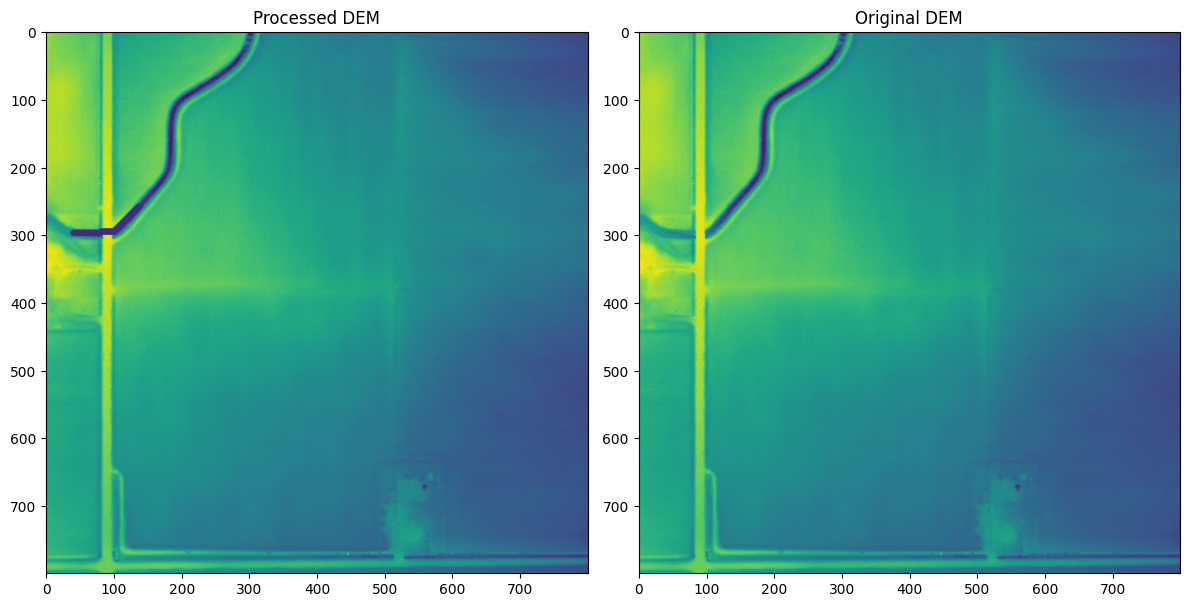

In [3]:
import matplotlib.pyplot as plt
from osgeo import gdal

# Load the first image
ds = gdal.Open(r"C:\Users\mikeb\Desktop\FRCNN_predict\edited1.tif")
data = ds.GetRasterBand(1).ReadAsArray()

# Load the second image
ds1 = gdal.Open(r"C:\Users\mikeb\Desktop\site_test16.TIF")
data1 = ds1.GetRasterBand(1).ReadAsArray()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image in the first subplot
axes[0].imshow(data)
axes[0].set_title('Processed DEM')

# Plot the second image in the second subplot
axes[1].imshow(data1)
axes[1].set_title('Original DEM')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()